# Fraud Detection with Deep Learning

Installing required external Libraries

In [ ]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

Downloading the helper functions designed by mrdbourke which contains custom functions

In [ ]:
! wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

Importing required functions from helper functions

In [1]:
from helper_functions import plot_loss_curves, make_confusion_matrix

## Importing Libraries

To start, we'll import all the necessary libraries to process the data and build the model.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
%matplotlib inline

## Data Loading

We'll load the dataset into a dataframe to explore its contents.

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Data/Fraud.csv")
df.head()

step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0

## Data Exploration

Before diving into modeling, it's essential to understand the structure, size, and distributions within the dataset.



Let's get a better understanding of our data's datatypes, size, and potential missing values.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Data Visualization

Visualizing the data can help in understanding its distribution and patterns. Here, we'll use histograms to visualize the distribution of each feature.

array([[<Axes: title={'center': 'step'}>,
        <Axes: title={'center': 'amount'}>,
        <Axes: title={'center': 'oldbalanceOrg'}>],
       [<Axes: title={'center': 'newbalanceOrig'}>,
        <Axes: title={'center': 'oldbalanceDest'}>,
        <Axes: title={'center': 'newbalanceDest'}>],
       [<Axes: title={'center': 'isFraud'}>,
        <Axes: title={'center': 'isFlaggedFraud'}>, <Axes: >]],
      dtype=object)

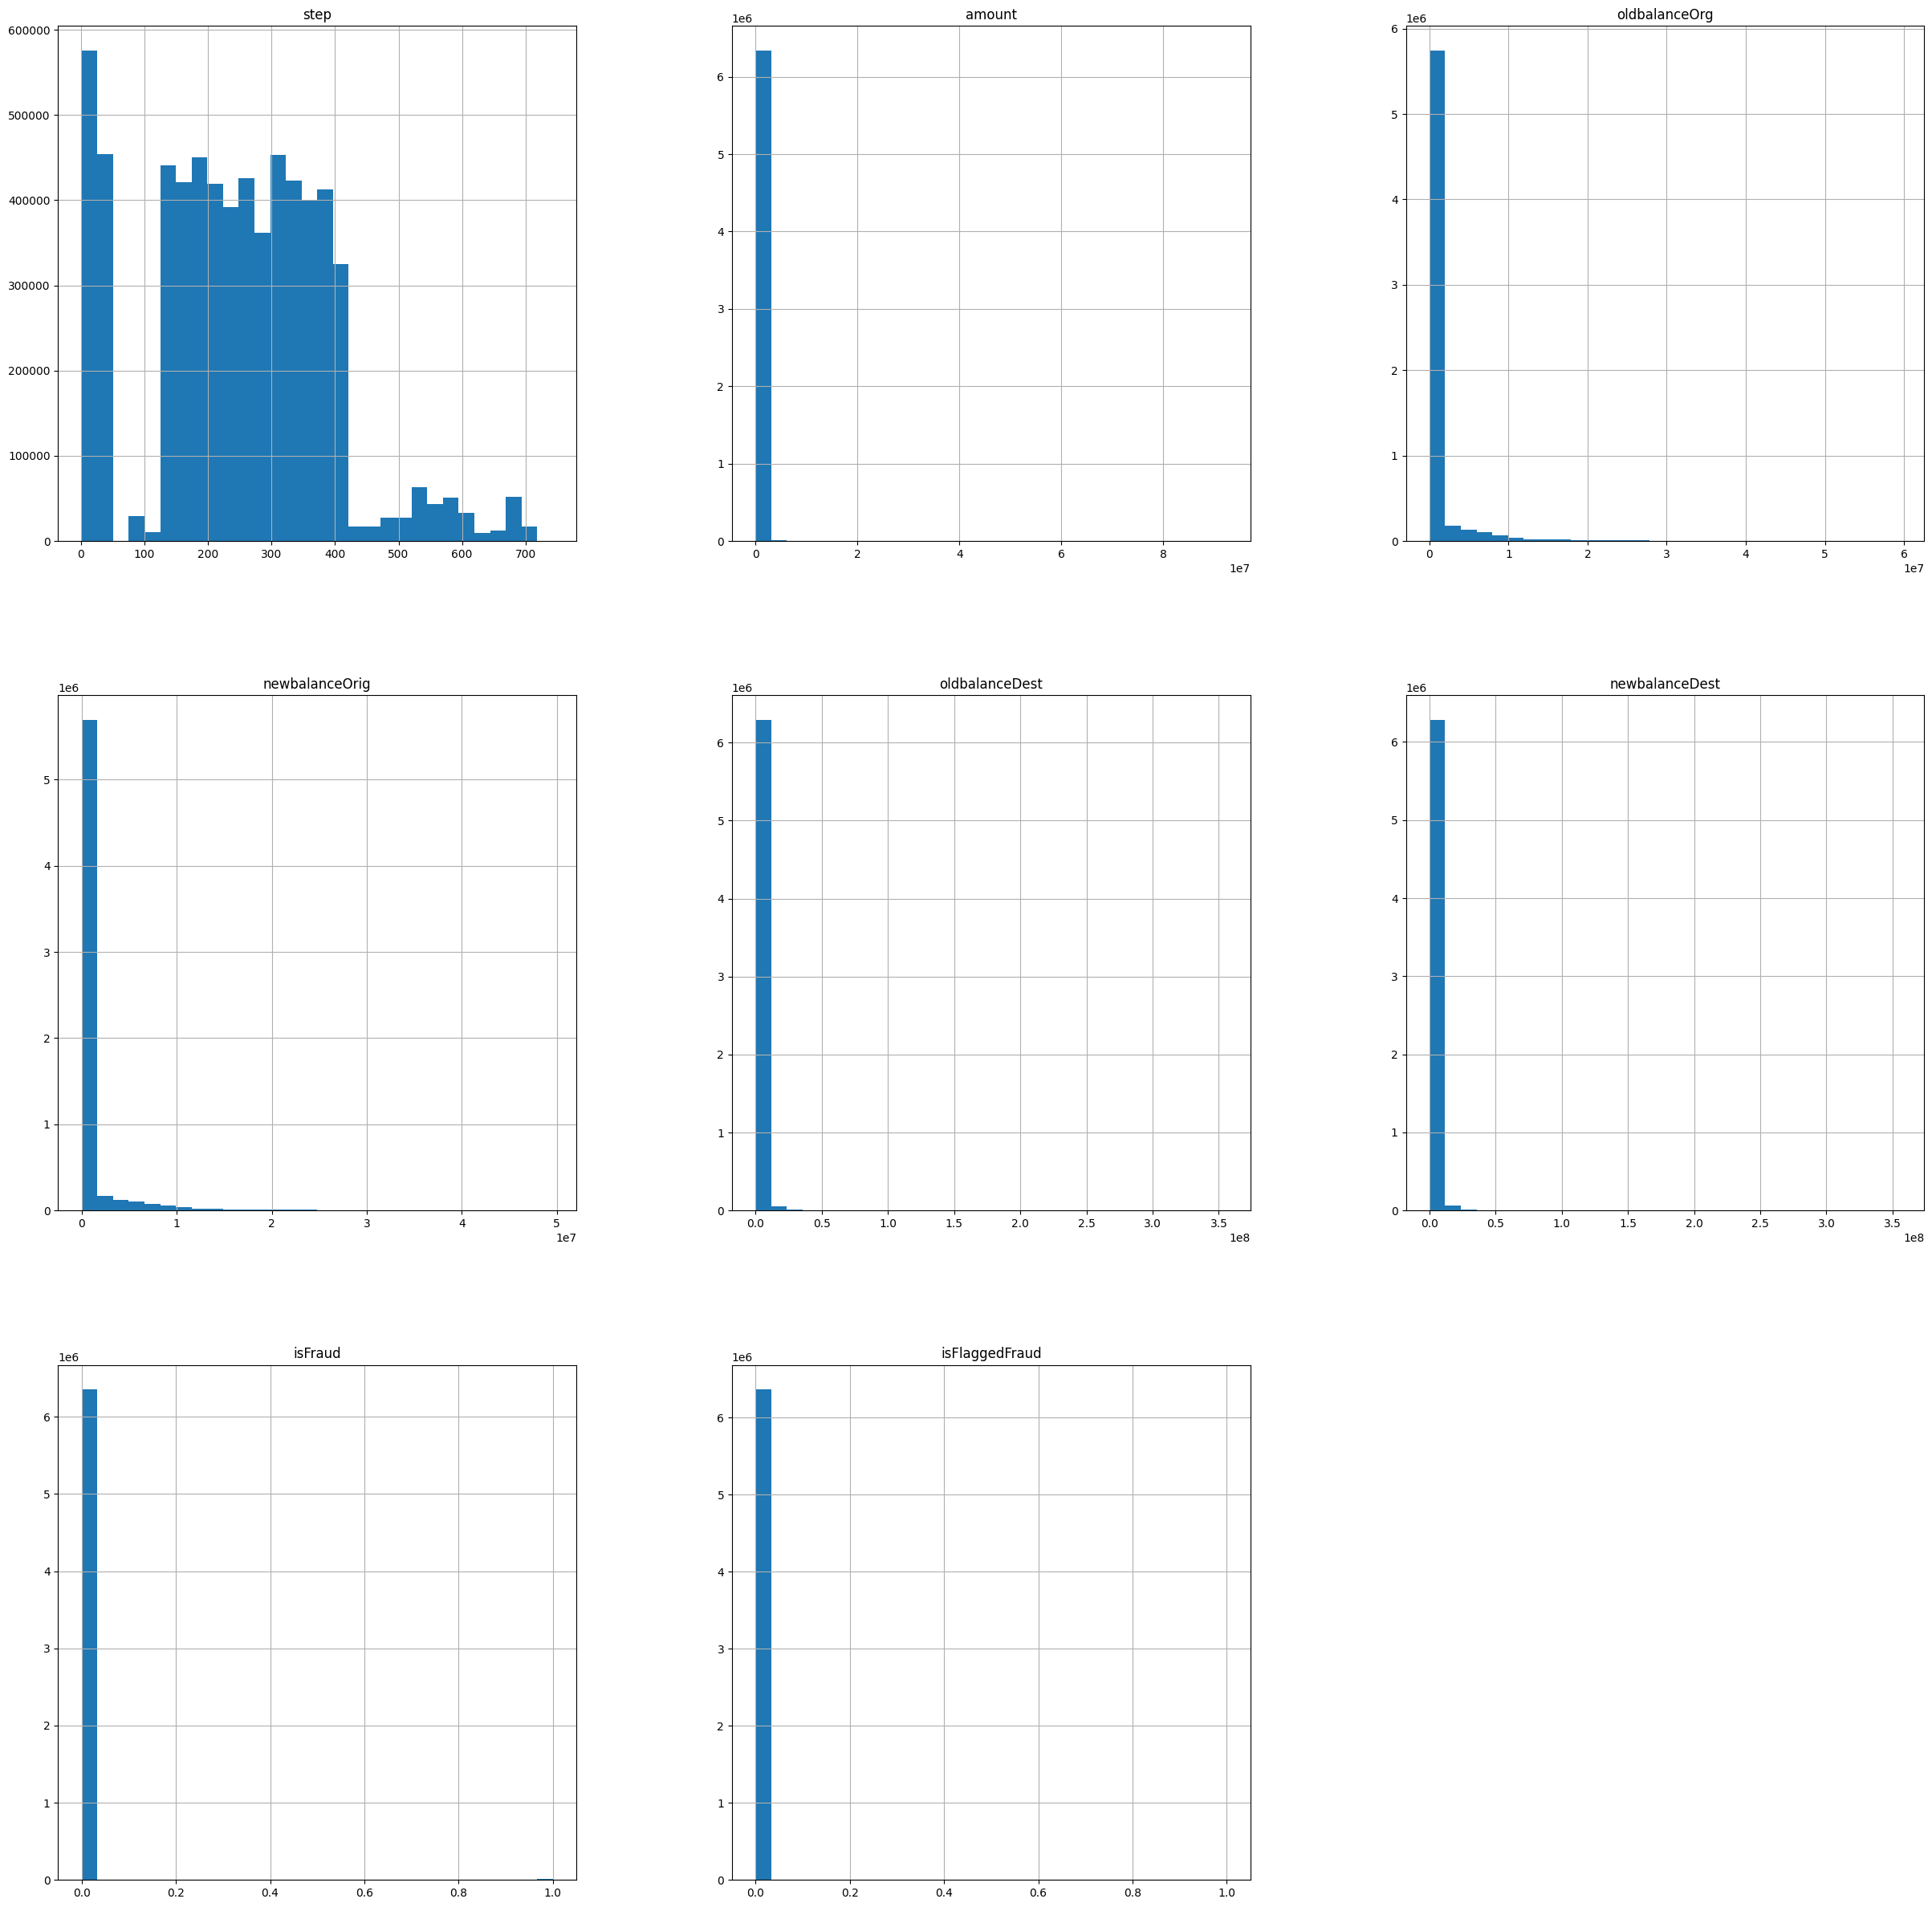

In [6]:
df.hist(bins = 30, figsize=(30,30))

In [7]:
df.describe()

step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.798619e+05   8.338831e+05    8.551137e+05   
std    1.423320e+02  6.038582e+05   2.888243e+06    2.924049e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e+00   
50%    2.390000e+02  7.487194e+04   1.420800e+04    0.000000e+00   
75%    3.350000e+02  2.087215e+05   1.073152e+05    1.442584e+05   
max    7.430000e+02  9.244552e+07   5.958504e+07    4.958504e+07   

       oldbalanceDest  newbalanceDest       isFraud  isFlaggedFraud  
count    6.362620e+06    6.362620e+06  6.362620e+06    6.362620e+06  
mean     1.100702e+06    1.224996e+06  1.290820e-03    2.514687e-06  
std      3.399180e+06    3.674129e+06  3.590480e-02    1.585775e-03  
min      0.000000e+00    0.000000e+00  0.000000e+00    0.000000e+00  
25%      0.000000e+00    0.000000e+00  0.000000e+00    0.000000e+00  
50%      1.327057e+05    2.146614e+05  0.000000e+00    0.000000e+00  
75%      9.430367e+05    1.111909e+06  0.000000e+00    0.000000e+00  
max      3.560159e+08    3.561793e+08  1.000000e+00    1.000000e+00

## Detailed Profiling using pandas_profiling

For a more in-depth exploration, we'll use the `pandas_profiling` library to generate a comprehensive report on the dataset.


In [31]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df, explorative=True)
profile.to_notebook_iframe()

<ipython-input-31-440d0632e2c1>:1: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## 5. Data Preprocessing

With a good understanding of our dataset, we now move on to preprocessing. This includes scaling numerical features, encoding categorical variables, and handling any imbalances in our target variable.


> Multicollinearity Problem

When using deep neural networks, multicollinearity is less of a concern than it is for linear models. Neural networks, with their complex architectures and non-linear activation functions, can navigate through and even exploit the correlations between features. However, it's essential to monitor the training process and watch for overfitting, especially when using deep architectures.






Copying the main dataframe to another in form of backup

In [32]:
df1 = df.copy()

First, we'll scale numeric features to ensure our model can process them efficiently. For this purpose, we'll use the `RobustScaler`specially to deal with the outilers.

In [34]:
from sklearn.preprocessing import RobustScaler
rs = RobustScaler()
df1['amount'] = rs.fit_transform(df1['amount'].to_numpy().reshape(-1, 1))
df1['oldbalanceOrg'] = rs.fit_transform(df1['oldbalanceOrg'].to_numpy().reshape(-1, 1))
df1['newbalanceOrig'] = rs.fit_transform(df1['newbalanceOrig'].to_numpy().reshape(-1, 1))
df1['oldbalanceDest'] = rs.fit_transform(df1['oldbalanceDest'].to_numpy().reshape(-1, 1))
df1['newbalanceDest'] = rs.fit_transform(df1['newbalanceDest'].to_numpy().reshape(-1, 1))

Distribution after applying  `RobustScaler`






array([[<Axes: title={'center': 'step'}>,
        <Axes: title={'center': 'amount'}>,
        <Axes: title={'center': 'oldbalanceOrg'}>],
       [<Axes: title={'center': 'newbalanceOrig'}>,
        <Axes: title={'center': 'oldbalanceDest'}>,
        <Axes: title={'center': 'newbalanceDest'}>],
       [<Axes: title={'center': 'isFraud'}>,
        <Axes: title={'center': 'isFlaggedFraud'}>, <Axes: >]],
      dtype=object)

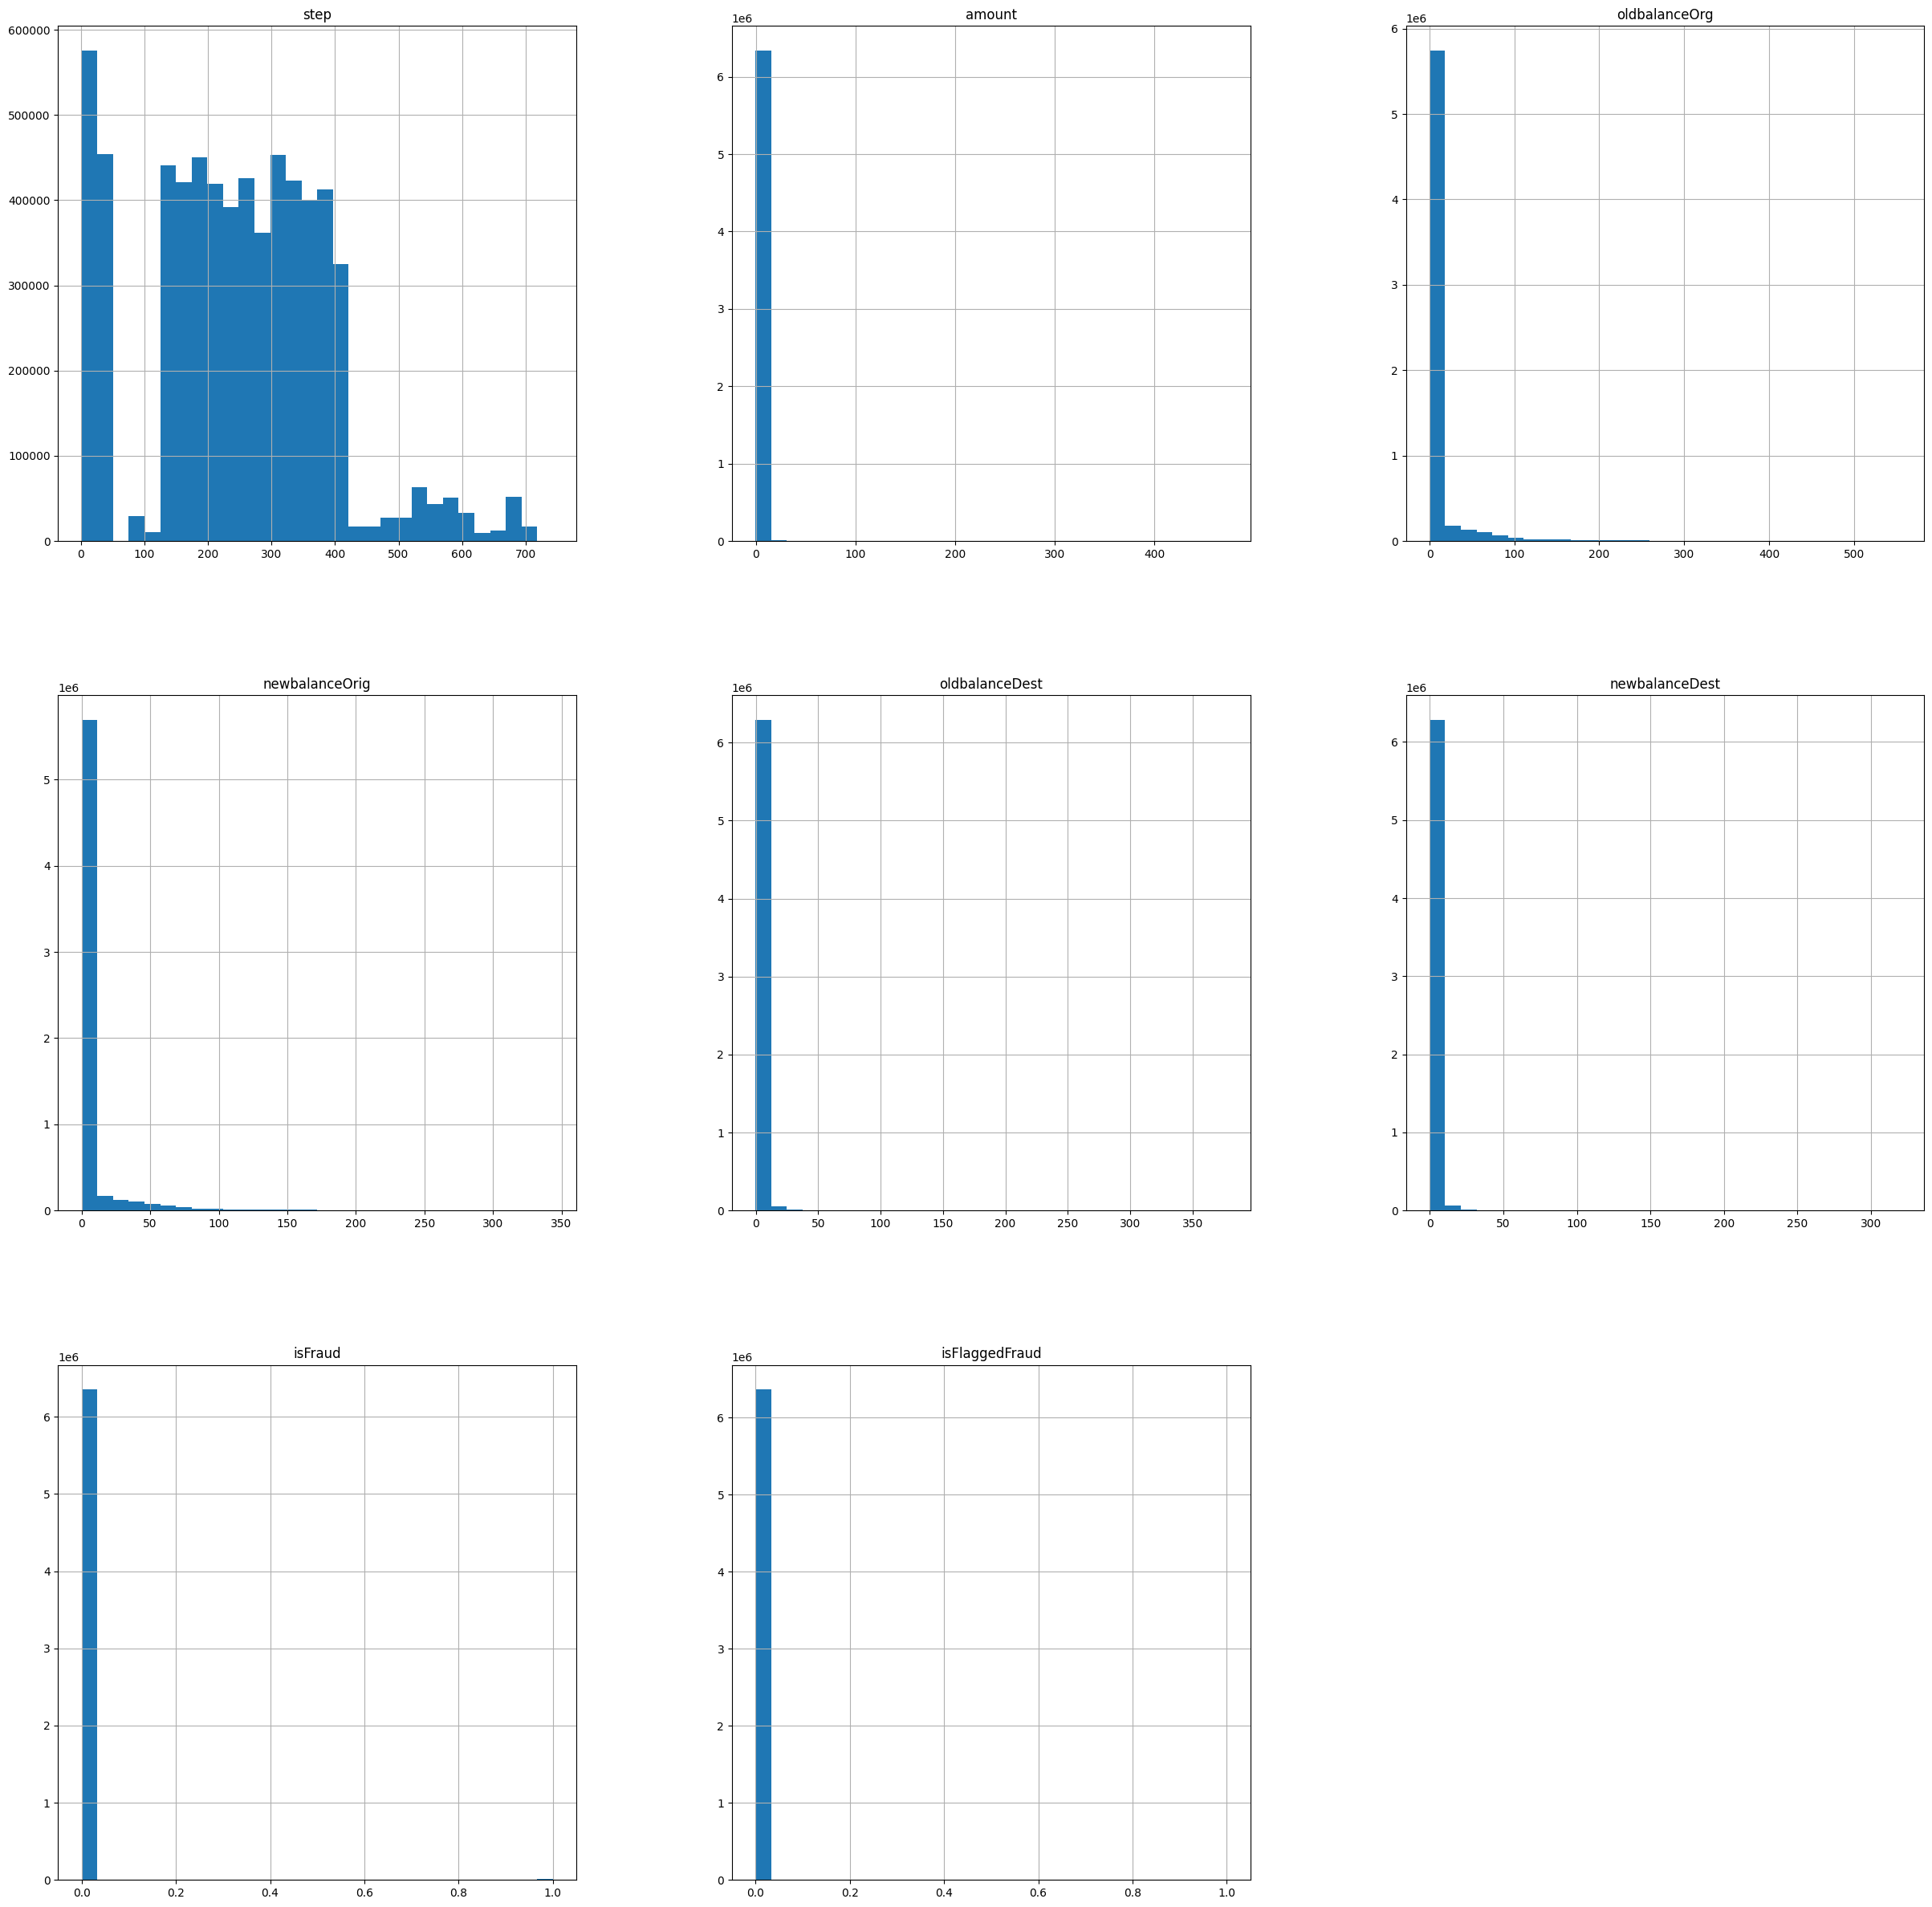

In [35]:
df1.hist(bins = 30, figsize=(30,30))

End result

In [36]:
df1.head()

step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT -0.332932  C1231006815       1.452991        1.111175   
1     1   PAYMENT -0.373762  C1666544295       0.065610        0.134375   
2     1  TRANSFER -0.382380  C1305486145      -0.130708        0.000000   
3     1  CASH_OUT -0.382380   C840083671      -0.130708        0.000000   
4     1   PAYMENT -0.323571  C2048537720       0.254820        0.207169   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155       -0.140722       -0.193057        0               0  
1  M2044282225       -0.140722       -0.193057        0               0  
2   C553264065       -0.140722       -0.193057        1               0  
3    C38997010       -0.118260       -0.193057        1               0  
4  M1230701703       -0.140722       -0.193057        0               0

Dropping unnecessary columns

In [37]:
df1.drop(['nameOrig','nameDest','isFlaggedFraud'], axis = 1, inplace = True)

Applying one-hot encoding on categorical variable **type**

In [38]:
df1 = pd.get_dummies(df1, columns = ['type'])

In [39]:
df1.head()

step    amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0     1 -0.332932       1.452991        1.111175       -0.140722   
1     1 -0.373762       0.065610        0.134375       -0.140722   
2     1 -0.382380      -0.130708        0.000000       -0.140722   
3     1 -0.382380      -0.130708        0.000000       -0.118260   
4     1 -0.323571       0.254820        0.207169       -0.140722   

   newbalanceDest  isFraud  type_CASH_IN  type_CASH_OUT  type_DEBIT  \
0       -0.193057        0             0              0           0   
1       -0.193057        0             0              0           0   
2       -0.193057        1             0              0           0   
3       -0.193057        1             0              1           0   
4       -0.193057        0             0              0           0   

   type_PAYMENT  type_TRANSFER  
0             1              0  
1             1              0  
2             0              1  
3             0              0  
4             1              0

Checking if data is imbalanced or not

In [40]:
df1['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

## 6. Preparing Data for Modeling

Before training, we need to split our data and ensure it's in the right format. We'll also address **Isfraud** target variable imbalance using undersampling.

 Addressing `Isfraud ` imbalance using undersampling.

In [41]:
not_frauds = df1.query('isFraud == 0')
frauds = df1.query('isFraud == 1')
not_frauds['isFraud'].value_counts(), frauds['isFraud'].value_counts()

(0    6354407
 Name: isFraud, dtype: int64,
 1    8213
 Name: isFraud, dtype: int64)

Creating new dataframe which contains balanced classes

In [42]:
under_df = pd.concat([frauds, not_frauds.sample(len(frauds), random_state=1)])
under_df['isFraud'].value_counts()

1    8213
0    8213
Name: isFraud, dtype: int64

Splitting undersampled data into independent and dependent features

In [43]:
X = under_df.drop(['isFraud'], axis = 1)
y = under_df['isFraud']

Spliting the undersampled data into training and test set

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state = 42)

In [45]:
y_train.value_counts()

0    6576
1    6564
Name: isFraud, dtype: int64

Applying feature scaling `MinMaxScaler` on train and test data

In [46]:
from sklearn.preprocessing import MinMaxScaler

# Create a scaler object
sc =  MinMaxScaler()

# Fit on the training data
X_train.iloc[:, :6] = sc.fit_transform(X_train.iloc[:, :6])

# Transform the validation/test data
X_test.iloc[:, :6] = sc.transform(X_test.iloc[:, :6])

## 7. Building the Deep Learning Model

Now that our data is ready, we'll construct a deep learning model using TensorFlow and Keras.

Deep Neural Network Architecture

In [47]:
from tensorflow.keras import layers
model = tf.keras.Sequential([
    layers.InputLayer(X_train.shape[1]),
    layers.Dense(64, activation = 'relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.3),
    layers.Dense(512, activation = 'relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation = 'sigmoid')

])


model.compile(loss= 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

Fitting and training model on training set

In [48]:
history = model.fit(X_train, y_train, validation_split = 0.2, epochs = 20)

Epoch 1/20
329/329 [==============================] - 3s 5ms/step - loss: 0.3836 - accuracy: 0.8056 - val_loss: 0.3299 - val_accuracy: 0.8360
Epoch 2/20
329/329 [==============================] - 2s 5ms/step - loss: 0.3211 - accuracy: 0.8428 - val_loss: 0.3108 - val_accuracy: 0.8455
Epoch 3/20
329/329 [==============================] - 2s 6ms/step - loss: 0.2954 - accuracy: 0.8618 - val_loss: 0.2721 - val_accuracy: 0.8699
Epoch 4/20
329/329 [==============================] - 2s 6ms/step - loss: 0.2676 - accuracy: 0.8783 - val_loss: 0.2359 - val_accuracy: 0.8946
Epoch 5/20
329/329 [==============================] - 4s 12ms/step - loss: 0.2456 - accuracy: 0.8927 - val_loss: 0.2145 - val_accuracy: 0.9064
Epoch 6/20
329/329 [==============================] - 4s 11ms/step - loss: 0.2278 - accuracy: 0.8994 - val_loss: 0.2196 - val_accuracy: 0.8957
Epoch 7/20
329/329 [==============================] - 3s 9ms/step - loss: 0.2199 - accuracy: 0.9040 - val_loss: 0.2006 - val_accuracy: 0.9094
Epoc

## 8. Model Evaluation

Post-training, we'll evaluate our model's performance using various metrics and visualizations.

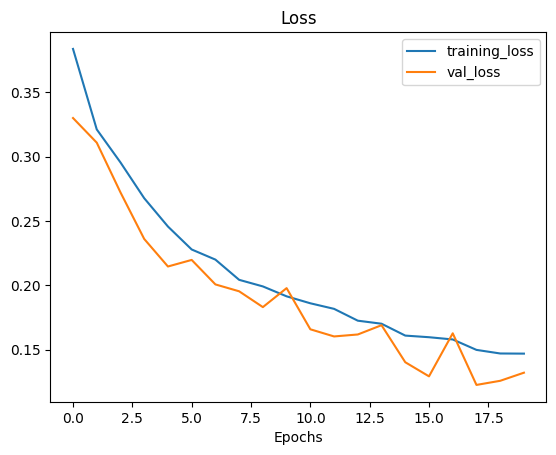

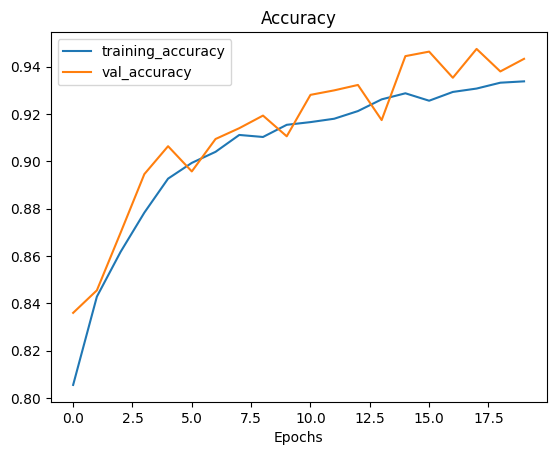

In [49]:
plot_loss_curves(history)

In [50]:
y_prob = model.predict(X_test)
y_pred = tf.round(y_prob)

103/103 [==============================] - 0s 2ms/step


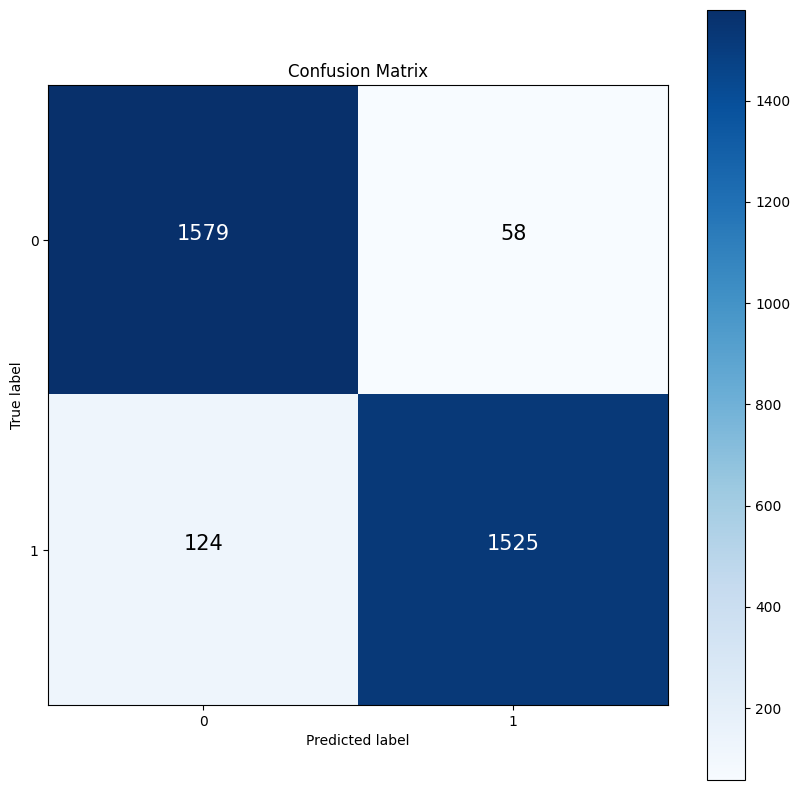

In [51]:
make_confusion_matrix(y_test, y_pred)

### Detailed Classification Report

For a more granular understanding of our model's performance, we'll use the `classification_report` from scikit-learn. This report will provide key metrics like precision, recall, and F1-score for each class.

In [52]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names = ['Not Fraud','Fraud']))

              precision    recall  f1-score   support

   Not Fraud       0.93      0.96      0.95      1637
       Fraud       0.96      0.92      0.94      1649

    accuracy                           0.94      3286
   macro avg       0.95      0.94      0.94      3286
weighted avg       0.95      0.94      0.94      3286








> Conclusion



The model, trained using undersampling to address class imbalance, effectively detects fraudulent transactions using transaction amounts, balances, and types. With real-time processing and regular updates, it adapts to evolving fraud patterns. Its efficacy is monitored through false positives/negatives





 ## **Expected** questions to be answered

1. Data Cleaning including Missing Values, Outliers, and Multi-collinearity:

* **Missing Values**: The code used **df.isnull().sum()** to check for missing values in the dataset.

* **Outliers**: Outliers, especially in features like 'amount', were addressed by using the RobustScaler, which is less sensitive to outliers.

* **Multi-collinearity**: While the deep neural network model used can handle multicollinearity to some extent, it's always good to be aware of it. Deep learning models with their non-linear activation functions can navigate through and exploit correlations between features.

2. Describe your Fraud Detection Model in Elaboration:

* The model is a deep neural network built using TensorFlow and Keras. It has multiple dense layers, combined with dropout layers to prevent overfitting. The model uses the 'relu' activation function for internal layers and 'sigmoid' for the final layer, making it suitable for binary classification.

3. How did you Select Variables to be Included in the Model?

* Variables were selected based on their relevance to the target variable.
* Unnecessary columns like 'nameOrig', 'nameDest', and 'isFlaggedFraud' were dropped.
* The categorical 'type' column was one-hot encoded to be used in the model.

4. Demonstrate the Performance of the Model by using the Best Set of Tools:

* The model's performance was demonstrated using accuracy plots, confusion matrices, and a detailed classification report.
* These tools give a comprehensive view of the model's performance on both classes.

5. What are the Key Factors that Predict Fraudulent Customer?

* All available features after preprocessing (such as 'amount', 'oldbalanceOrg', etc., including the one-hot encoded 'type' features) are used by the model to predict fraud.

6. Do these Factors Make Sense? If yes, How? If not, How not?

* Yes, they do. Transaction amounts, old balances, and new balances can provide patterns typical of fraudulent activities. The type of transaction can also be indicative of fraud.
* For instance, certain types of transactions might be more prone to fraud than others.

7. What Kind of Prevention Should be Adopted while the Company Updates its Infrastructure?

* **Ensure data integrity**: As data is the backbone of this model, the infrastructure should prioritize data quality and integrity.

* **Real-time processing**: The infrastructure should be capable of real-time fraud detection to prevent fraudulent transactions promptly.

* **Regular model updates**: As fraud patterns evolve, the model should be retrained periodically with new data.
Implement multi-factor authentication and other security measures for transactions that the model flags as high risk.

8. Assuming these Actions have been Implemented, How Would You Determine if They Work?

* Monitor the false positive and false negative rates. An effective system should minimize both.
* Track the number of fraudulent transactions that go undetected versus those caught.
* Collect feedback from users. If genuine transactions are frequently flagged, it indicates a high false positive rate.
* Regularly evaluate the model's performance on new, unseen data to ensure it remains effective over time.

